In [2]:
!dcm2niix -h
#!dcm2niix Brain_T1_scan_Patient1

Chris Rorden's dcm2niiX version v1.0.20190902  (JP2:OpenJPEG) (JP-LS:CharLS) MSC1900 (64-bit Windows)
usage: dcm2niix [options] <in_folder>
 Options :
  -1..-9 : gz compression level (1=fastest..9=smallest, default 6)
  -a : adjacent DICOMs (images from same series always in same folder) for faster conversion (n/y, default n)
  -b : BIDS sidecar (y/n/o [o=only: no NIfTI], default y)
   -ba : anonymize BIDS (y/n, default y)
  -c : comment stored in NIfTI aux_file (provide up to 24 characters)
  -d : directory search depth. Convert DICOMs in sub-folders of in_folder? (0..9, default 5)
  -e : export as NRRD instead of NIfTI (y/n, default n)
  -f : filename (%a=antenna (coil) name, %b=basename, %c=comments, %d=description, %e=echo number, %f=folder name, %i=ID of patient, %j=seriesInstanceUID, %k=studyInstanceUID, %m=manufacturer, %n=name of patient, %p=protocol, %r=instance number, %s=series number, %t=time, %u=acquisition number, %v=vendor, %x=study ID; %z=sequence name; default '%f_%p_%

In [2]:
!pip install nibabel

In [3]:
import nibabel as nib

file_path = "Nifti_Brain/Brain_T1_scan_Patient1_Sag_T1_MPRAGE_1x1x1_20210108134957_2.nii"
img=nib.load(file_path)
data=img.get_fdata()

In [5]:
data[50].shape
print(data[50].max())
print(data[50].min())
print(data.max())
print(data.min())

3662.0
0.0
5326.0
0.0


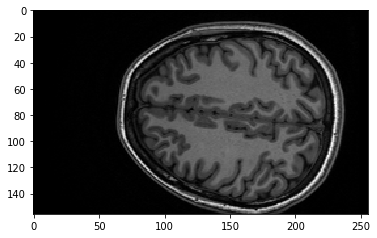

In [7]:
import matplotlib.pyplot as plt
import numpy as np

#Rotate images
for i in range(len(data)):
    data[i] = np.rot90(data[i],axes=(-2,-1))
    
#plt.imshow(data[50], interpolation='nearest')
plt.imshow(data[:,:,50], cmap='gray')
plt.show()


In [8]:
grey_im = (data[:,:,50]*(255/data[:,:,50].max())).astype(np.uint8)

In [9]:
print(grey_im.max())

255


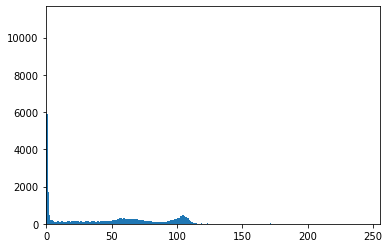

In [10]:
#https://stackoverflow.com/questions/22159160/python-calculate-histogram-of-image
counts, bins = np.histogram(grey_im, range(256))
# plot histogram centered on values 0..255

plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.show()

In [14]:
!pip install opencv-python

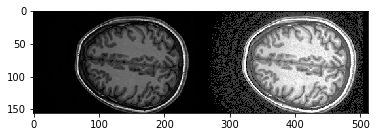

72


In [16]:
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
import cv2


img = grey_im
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side

plt.imshow(res, cmap='gray')
plt.show()
print(img[20][200])

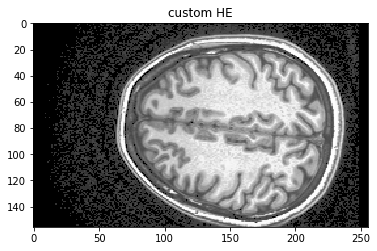

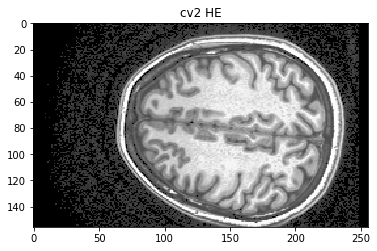

In [18]:
#Own implementation of the histogram equalization

#The goal of the H.E is to have a linear cumulative distribution function (cdf)
#a cross the range of intensity to have a better use of all possible intensities.
#
import math


def hist_equalizer(img):
    
    result = np.zeros(img.shape).astype(np.uint8)
    
    #Set the range of intensity of the image between 0 and 255 and as unsigned integers
    grey_im = (img*(255/img.max())).astype(np.uint8)
    
    #Create the histogram
    #We got up to 256 because the last bin is [255,256] while all the others are [n-1,n[
    #meaning that the last bin would have sum the pixels with value 254 and 255 if we had stop at 255
    counts, bins = np.histogram(grey_im.flatten(),256, [0,256])
    
    #Create the cdf
    cdf = counts.cumsum()
    cdf_min = cdf[np.nonzero(cdf)[0][0]] #first element that is not zero
    
    i_max, j_max = img.shape
    
    for i in range(i_max):
        for j in range(j_max):
            #value in the original image to be transformed
            val = grey_im[i][j]

            #we just take the normalized cdf of the value by the inverse distribution 
            #function (quantile function) multiply it by 255 (the max range) and round the result
            result[i][j] = math.floor((cdf[val] - cdf_min)/(i_max*j_max - cdf_min)*(256-1))

    return result

custom_res = hist_equalizer(data[:,:,50])

plt.imshow(custom_res,cmap='gray')
plt.title("custom HE")
plt.show()

plt.imshow(equ,cmap='gray')
plt.title("cv2 HE")
plt.show()

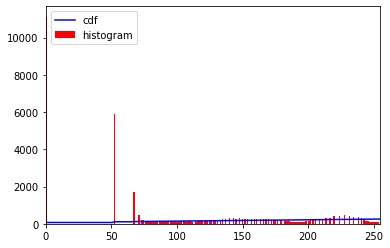

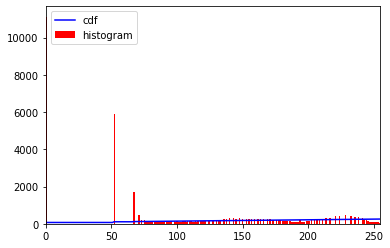

In [19]:
#Comparing histogram of custom and cv2 histogram equalizer

hists, bins = np.histogram(custom_res, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(custom_res.flatten(), 256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

hists, bins = np.histogram(equ, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

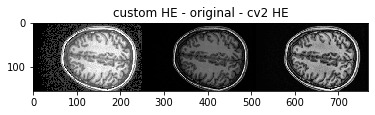

In [20]:
#Contrast-limited adaptive histogram equalization (CLAHE) consist of dividing the image into tiles
#and apply the equalization localy. There is also a threshold to limit the contrast
#TODO better explanation

img = grey_im
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #grid of 8 by 8
cl1 = clahe.apply(img)
res = np.hstack((custom_res,img,cl1))
plt.imshow(res, cmap='gray')
plt.title('custom HE - original - cv2 HE')
plt.show()

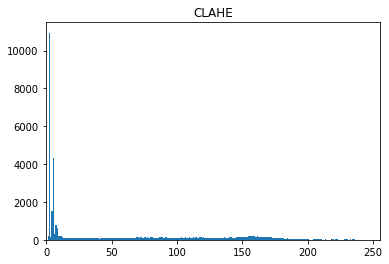

In [21]:
counts, bins = np.histogram(cl1, range(257))
# plot histogram centered on values 0..255
plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.title("CLAHE")
plt.show()

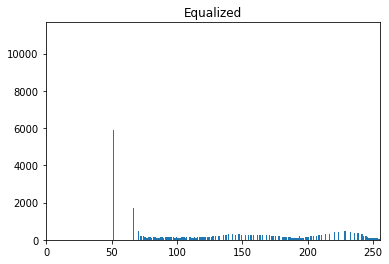

In [22]:
counts, bins = np.histogram(equ, range(257))
# plot histogram centered on values 0..255
plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.title("Equalized")
plt.show()

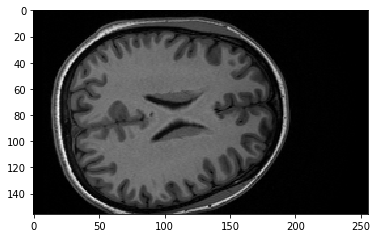

In [50]:
plt.imshow(data[:,:,190], cmap='gray')
plt.show()

In [98]:
## Usefull functions cell 

from scipy.ndimage.morphology import binary_fill_holes
from scipy.stats import norm as normal
  
def getForegroundMask(originalBrainImg, backGroundValue=0):
    # Get a binary mask from a 2D array, where the pixels > 0 are set to 1
    foregroundMask = originalBrainImg > backGroundValue
    return binary_fill_holes(foregroundMask)

def getForegroundArray(originalBrainImg, foregroundMask):
    # Return a 1D array with the pixels from originalBrainImg which are under the foregroundmask
    return originalBrainImg[foregroundMask==1]
 
def plotHistogramWithDistribs(array, meansArray, stdsArray):
    # Plot the histogram of an array and gaussian distributions corresponding to meansArray / stdsArray
    plt.figure(figsize=(10, 10))
    hist, bin_edges = np.histogram(array, bins=255, normed=True)
    plt.bar(bin_edges[:-1], hist, align='center', width=0.005)
    plt.ylabel('Number of Pixels')
    plt.xlabel('Intensity')
    x = np.linspace(0, 1, 255)
    for (mean, std) in zip(meansArray, stdsArray):
        plt.plot(x, normal.pdf(x, mean, std), linewidth=1)
        
def plotHistogramWithTresholds(array, tresh):
    # Plot the histogram of an array and gaussian distributions corresponding to meansArray / stdsArray
    plt.figure(figsize=(10, 10))
    hist, bin_edges = np.histogram(array, bins=255, normed=True)
    plt.bar(bin_edges[:-1], hist, align='center', width=0.005)
    plt.ylabel('Number of Pixels')
    plt.xlabel('Intensity')
    x = np.linspace(0, 1, 255)
    for i in tresh:
        plt.axvline(x = i,color = 'red')

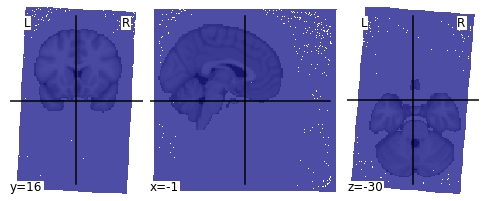

In [26]:
#!pip install nilearn
from nilearn import image
smoothed_img = image.smooth_img("Nifti_Brain/Brain_T1_scan_Patient1_Sag_T1_MPRAGE_1x1x1_20210108134957_2.nii",None)  

from nilearn.masking import compute_background_mask
mask_img = compute_background_mask(smoothed_img)
from nilearn.plotting import plot_roi
plot_roi(mask_img)

In [27]:
mask_img[:,:,50]

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

initialMeansArray [0.45 0.15 0.1 ]
initialStdsArray [0. 0. 0.]


C:\Users\MediMonster\anaconda3\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
C:\Users\MediMonster\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\MediMonster\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\MediMonster\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, d

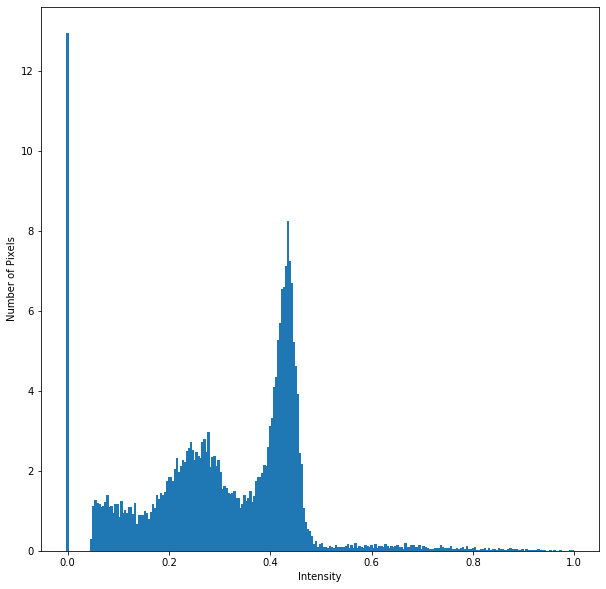

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
from skimage.color import rgb2grey

## Read and rescale image between 0 and 1 
originalBrainImg = data[:,:,190]

originalBrainImg = originalBrainImg / np.max(originalBrainImg)
for i in range(originalBrainImg.shape[0]):
    for j in range(originalBrainImg.shape[1]):
        if originalBrainImg[i,j]<0.05:
             originalBrainImg[i,j]=0.0

## Get only non zeros pixels from the image (Use functions from previous cell)
ZeroBrainImg = getForegroundArray(originalBrainImg,getForegroundMask(originalBrainImg,0.05))



## Define classes for the classification
classList = ['GreyMatter', 'WhiteMatter', 'CerebrospinalFluid']
numberOfClasses = len(classList)

## Initial conditions (You can change them)
initialMeansArray = np.array([0.45,0.15,0.1])
initialStdsArray = 0 * np.ones(numberOfClasses)
priorProbabilities = [0.33,0.33,0.33]

print('initialMeansArray', initialMeansArray)
print('initialStdsArray', initialStdsArray)
plotHistogramWithDistribs(ZeroBrainImg, initialMeansArray, initialStdsArray)

In [87]:
from IPython import display
import math as m
import random


def em(brainArray,pixelArray, meanArray, stdArray, priorProbs, tol=1e-4, max_iter=1000):
    
    ## TO COMPLETE
    
    ## ---------------------if you want to see the optimisation steps---------------------
    colorList = ['r', 'g', 'b']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    hist, bin_edges = np.histogram(pixelArray, bins=255, normed=True)
    ax.bar(bin_edges[:-1], hist, align='center', width=0.005)
    plt.ylabel('Number of Pixels')
    plt.xlabel('Grey Levels')
    x = np.linspace(0, 1, 255)
    ## -----------------------------------------------------------------------------------
    
    meansArray = meanArray.copy()
    stdsArray = stdArray.copy()
    mean_diff = 1
    std_diff = 1
    pixel_x = brainArray.shape[0]
    pixel_y = brainArray.shape[1]

    nb_set = meansArray.shape[0]
    
    uniquePixelValues,count = np.unique(pixelArray,return_counts = True)
    #pour enlever 0
    uniquePixelValues = uniquePixelValues[1:]

    count = count[1:]
    print(count)
    
    pixel_diff = uniquePixelValues.shape[0]
    
    # Create empty matrix of the shape you need
    pixels_class_probs = np.zeros((pixel_diff,nb_set))
    class_prob = np.zeros((pixel_diff,nb_set))
    for i in range(nb_set):
        pixels_class_probs[:,i] = (1.0/(m.sqrt(2*m.pi)*stdsArray[i]))*np.exp(-0.5*np.square((uniquePixelValues-meansArray[i])/stdsArray[i]))

    for iterNumber in range(max_iter):
        if (mean_diff < tol and std_diff < tol):
            break
        
        print('Iteration : ', iterNumber)
        
        # Step E(xpectaction)
        for i in range(nb_set):
            class_prob[:,i] = ((pixels_class_probs[:,i])*priorProbs[i])/np.sum(pixels_class_probs*priorProbs,axis=1)    
        
        

        # Step M(aximization)
        oldMean = meansArray.copy()
        oldStd = stdsArray.copy()
        for i in range(nb_set):
            meansArray[i] = np.sum(class_prob[:,i]*count*uniquePixelValues)/np.sum(count*class_prob[:,i])
            stdsArray[i] = m.sqrt(np.sum(count*class_prob[:,i]*(uniquePixelValues-meansArray[i])**2)/np.sum(count*class_prob[:,i]))

        
        
        
        # Update prior probabilities
        for i in range(nb_set):
            pixels_class_probs[:,i] = (1.0/(m.sqrt(2*m.pi)*stdsArray[i]))*np.exp(-0.5*np.square((uniquePixelValues-meansArray[i])/stdsArray[i]))
 
        
        # Compute convergence conditions to check in next iteration
        mean_diff = max(abs(meansArray-oldMean))
        std_diff = max(abs(stdsArray-oldStd))
        
        
        
         ## ---------------------if you want to see the optimisation steps---------------------
        for elem in ax.lines:
            elem.remove()
        for i in range(meansArray.shape[0]):
            ax.plot(x, normal.pdf(x, meansArray[i], stdsArray[i]), linewidth=1, color=colorList[i])
        display.clear_output(wait=True)
        display.display(plt.gcf())
        ##-----------------------------------------------------------------------------------
        

    
    SegmentedBrain = np.zeros((pixel_x,pixel_y))
    for i in range(pixel_diff):
        x,y = np.where(brainArray == uniquePixelValues[i])
        SegmentedBrain[x,y] = random.choices([1,2,3],weights = class_prob[i,:],k=len(x))
    print(uniquePixelValues)
    print(count)
        
    return class_prob, meansArray, stdsArray, SegmentedBrain

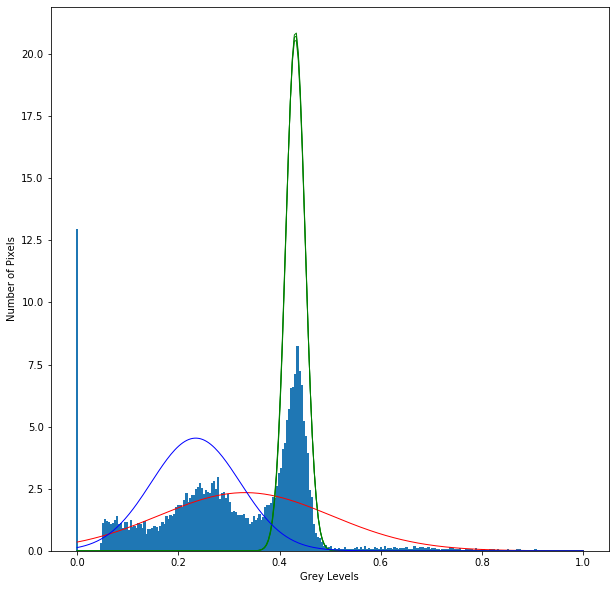

[0.05009529 0.05036755 0.0506398  ... 0.97576913 0.99373809 1.        ]
[5 5 9 ... 1 1 1]
[0.33155374 0.43142572 0.23419918]
[0.17027648 0.01906777 0.0879359 ]


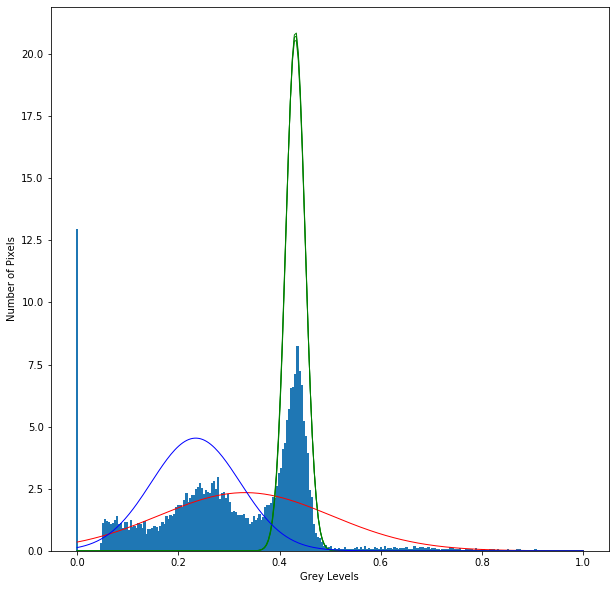

In [90]:
%matplotlib inline

class_prob, finalMeansArray, finalStdsArray,SegmentedBrain = em(originalBrainImg,
                                                 ZeroBrainImg,
                                                initialMeansArray, 
                                                initialStdsArray, 
                                                priorProbabilities, 
                                                tol=1e-3, 
                                                max_iter=100)

print(finalMeansArray)
print(finalStdsArray)

C:\Users\MediMonster\anaconda3\lib\site-packages\ipykernel_launcher.py:29: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


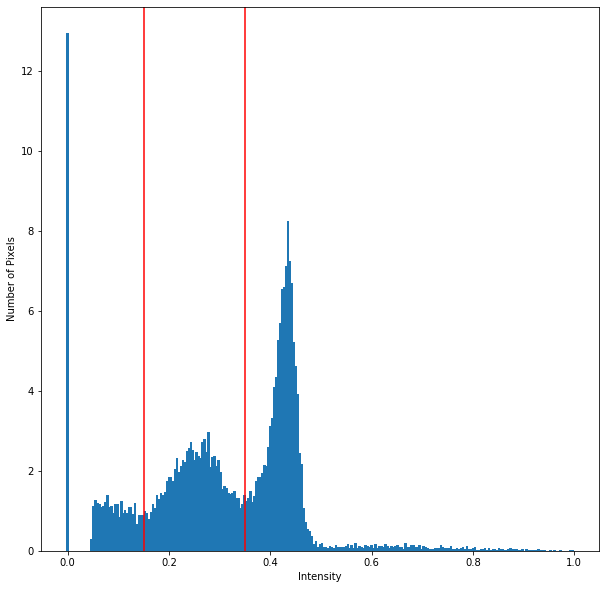

In [102]:
def OtsuSeg(BrainImg, tresh1,tresh2):
    SegmentedBrain = np.zeros(BrainImg.shape)
    for i in range(BrainImg.shape[0]):
        for j in range(BrainImg.shape[1]):
            if BrainImg[i,j] > 0 and BrainImg[i,j] <= tresh1 :
                SegmentedBrain[i,j] = 1/3
            elif BrainImg[i,j] > tresh1 and BrainImg[i,j] <= tresh2 :
                SegmentedBrain[i,j] = 2/3
            elif BrainImg[i,j] > tresh2:
                SegmentedBrain[i,j] = 1
    return SegmentedBrain
tresh = [0.15,0.35]
                
plotHistogramWithTresholds(ZeroBrainImg, tresh)
SegmentedBrain = OtsuSeg(originalBrainImg,0.15,0.35)

[0.33155374 0.43142572 0.23419918]
[0.17027648 0.01906777 0.0879359 ]


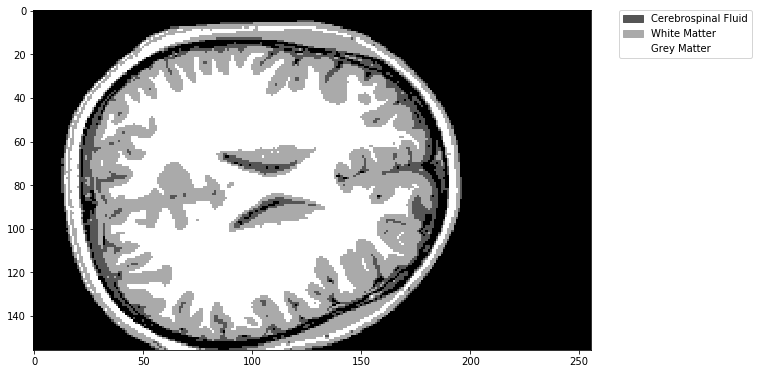

In [106]:
## Show EM segmentation results
import matplotlib.patches as mpatches

print(finalMeansArray)
print(finalStdsArray)

values = np.unique(SegmentedBrain.ravel())
values = values[1:]

plt.figure(figsize=(10,10))
im = plt.imshow(SegmentedBrain,cmap=plt.cm.gray)

# get the colors of the values, according to the 
# colormap used by imshow

colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
labels = {0:'Cerebrospinal Fluid',1:'White Matter',2:'Grey Matter'}

patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()
